In [327]:
import pandas as pd
import numpy as np
import ast
import os
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import numpy as np
import tensorflow as tf
import tensorflow.keras
import keras
from tensorflow.keras import layers
from keras.models import Sequential
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt
import plotly.io as plt_io
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
import plotly.express as px
import itertools
from sklearn.utils import class_weight
from tensorflow.keras.models import Model
import random
from sklearn.metrics import confusion_matrix, f1_score, roc_auc_score, roc_curve, auc, classification_report
import pickle
import plotly.graph_objects as go
from sklearn.decomposition import PCA

%matplotlib inline

In [328]:
songs_df = pd.read_csv('data/cleaned_songs.csv')
songs_df.head()

,artist_name,id,track_name,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,genres,track_pop,genres_list,subjectivity,polarity
0,Missy Elliott,0UaMYEvWZi0ZqiDOoHU3YI,Lose Control (feat. Ciara & Fat Man Scoop),0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,dance_pop hip_hop hip_pop pop pop_rap r&b rap ...,69,"['dance_pop', 'hip_hop', 'hip_pop', 'pop', 'po...",low,Neutral
1,Britney Spears,6I9VzXrHxO9rA9A5euc8Ak,Toxic,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,dance_pop pop post-teen_pop,83,"['dance_pop', 'pop', 'post-teen_pop']",low,Neutral
2,Beyoncé,0WqIKmW4BTrj3eJFmnCKMv,Crazy In Love,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,dance_pop pop r&b,25,"['dance_pop', 'pop', 'r&b']",high,Negative
3,Justin Timberlake,1AWQoqb9bSvzTjaLralEkT,Rock Your Body,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,dance_pop pop,79,"['dance_pop', 'pop']",low,Neutral
4,Shaggy,1lzr43nnXAijIGYnCT8M8H,It Wasn't Me,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,pop_rap reggae_fusion,2,"['pop_rap', 'reggae_fusion']",low,Neutral


In [329]:
# drop rows with identical artist_name and track_name
songs_df = songs_df.drop_duplicates(subset=['artist_name', 'track_name'], keep='first')
#add column with the first item in the genres list
songs_df['genre'] = songs_df['genres_list'].apply(lambda x: ast.literal_eval(x)[0])
#drop subjectivity, polarity, genres, genre list and identifiers
songs_df = songs_df.drop(columns=['subjectivity', 'polarity', 'genres', 'genres_list', 'track_name', 'artist_name'])
#drop rows with unknown genre
songs_df = songs_df[songs_df['genre'] != 'unknown']
songs_df.head(25)

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,track_pop,genre
0,0UaMYEvWZi0ZqiDOoHU3YI,0.904,0.813,4,-7.105,0,0.1210,0.031100,0.006970,0.0471,0.810,125.461,74,69,dance_pop
1,6I9VzXrHxO9rA9A5euc8Ak,0.774,0.838,5,-3.914,0,0.1140,0.024900,0.025000,0.2420,0.924,143.040,84,83,dance_pop
2,0WqIKmW4BTrj3eJFmnCKMv,0.664,0.758,2,-6.583,0,0.2100,0.002380,0.000000,0.0598,0.701,99.259,86,25,dance_pop
3,1AWQoqb9bSvzTjaLralEkT,0.892,0.714,4,-6.055,0,0.1410,0.201000,0.000234,0.0521,0.817,100.972,82,79,dance_pop
4,1lzr43nnXAijIGYnCT8M8H,0.853,0.606,0,-4.596,1,0.0713,0.056100,0.000000,0.3130,0.654,94.759,75,2,pop_rap
5,0XUfyU2QviPAs6bxSpXYG4,0.881,0.788,2,-4.669,1,0.1680,0.021200,0.000000,0.0377,0.592,104.997,82,0,atl_hip_hop
6,68vgtRHr7iZHpzGpon6Jlo,0.662,0.507,5,-8.238,1,0.1180,0.257000,0.000000,0.0465,0.676,86.412,82,79,atl_hip_hop
7,3BxWKCI06eQ5Od8TY2JBeA,0.570,0.821,2,-4.380,1,0.2670,0.178000,0.000000,0.2890,0.408,210.857,72,67,dance_pop
8,7H6ev70Weq6DdpZyyTmUXk,0.713,0.678,5,-3.525,0,0.1020,0.273000,0.000000,0.1490,0.734,138.009,75,78,dance_pop
9,2PpruBYCo4H7WOBJ7Q2EwM,0.727,0.974,4,-2.261,0,0.0664,0.103000,0.000532,0.1740,0.965,79.526,77,82,atl_hip_hop


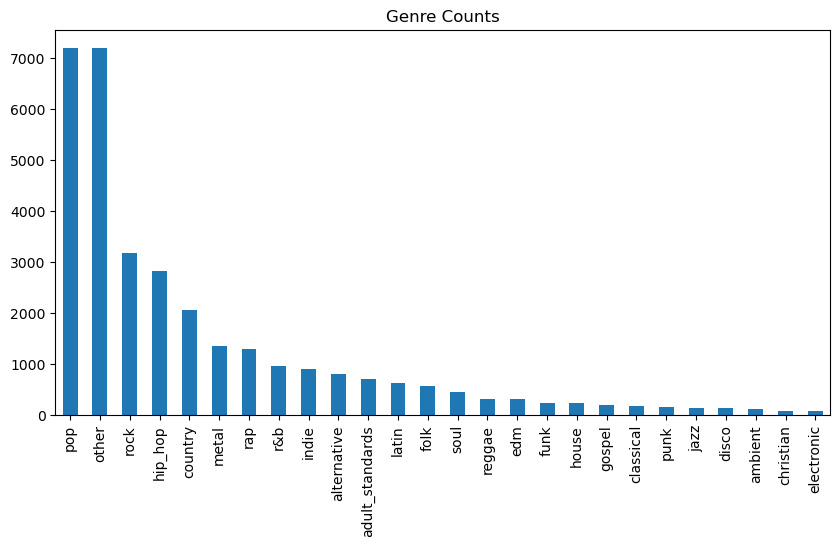

0.2234472049689441
26


In [330]:
#create empty list of length of the dataframe
genre_group = np.empty((len(songs_df), 1)).tolist()
others = []

#add a column that groups genres into categories being pop, rock, hip hop, metal, country, rap, r&b, edm, jazz, soul, blues, reggae, classical, folk
for i, genre in enumerate(songs_df['genre']):

    if 'pop' in genre:
        genre_group[i] = 'pop'
    elif 'rock' in genre:
        genre_group[i] = 'rock'
    elif 'hip_hop' in genre:
        genre_group[i] = 'hip_hop'
    elif 'country' in genre:
        genre_group[i] = 'country'
    elif 'rap' in genre:
        genre_group[i] = 'rap'
    elif 'r&b' in genre:
        genre_group[i] = 'r&b'
    elif 'edm' in genre:
        genre_group[i] = 'edm'
    elif 'jazz' in genre:
        genre_group[i] = 'jazz'
    elif 'soul' in genre:
        genre_group[i] = 'soul'
    elif 'reggae' in genre:
        genre_group[i] = 'reggae'
    elif 'classical' in genre:
        genre_group[i] = 'classical'
    elif 'folk' in genre:
        genre_group[i] = 'folk'
    elif 'metal' in genre:
        genre_group[i] = 'metal'
    elif 'latin' in genre:
        genre_group[i] = 'latin'
    elif 'christian' in genre:
        genre_group[i] = 'christian'
    elif 'gospel' in genre:
        genre_group[i] = 'gospel'
    elif 'indie' in genre:
        genre_group[i] = 'indie'
    elif 'electronic' in genre:
        genre_group[i] = 'electronic'
    elif 'disco' in genre:
        genre_group[i] = 'disco'
    elif 'punk' in genre:
        genre_group[i] = 'punk'
    elif 'funk' in genre:
        genre_group[i] = 'funk'
    elif 'alternative' in genre:
        genre_group[i] = 'alternative'
    elif 'ambient' in genre:
        genre_group[i] = 'ambient'
    elif 'house' in genre:
        genre_group[i] = 'house'
    elif 'adult_standards' in genre:
        genre_group[i] = 'adult_standards'
    else:
        genre_group[i] = 'other'
        others.append(genre)


#make a dictionaty to ttranslate tthese things dict reanslatte what to what

        
#print the value counts of the genres in a grid
pd.Series(genre_group).value_counts().plot(kind='bar', figsize=(10, 5), title='Genre Counts')
plt.show()
#find the number of items in the 'other' category
other_count = pd.Series(genre_group).value_counts()['other']
#divide the number of items in the 'other' category by the total number of items
print(other_count / len(songs_df))
#find the number of unique genres
print(len(pd.Series(genre_group).value_counts()))

In [331]:
#add the genre_group column to the dataframe
songs_df['genre_group'] = genre_group
#drop the genre column
songs_df = songs_df.drop(columns=['genre'])

In [332]:
songs_df.head()

,id,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,artist_pop,track_pop,genre_group
0,0UaMYEvWZi0ZqiDOoHU3YI,0.904,0.813,4,-7.105,0,0.1210,0.03110,0.006970,0.0471,0.810,125.461,74,69,pop
1,6I9VzXrHxO9rA9A5euc8Ak,0.774,0.838,5,-3.914,0,0.1140,0.02490,0.025000,0.2420,0.924,143.040,84,83,pop
2,0WqIKmW4BTrj3eJFmnCKMv,0.664,0.758,2,-6.583,0,0.2100,0.00238,0.000000,0.0598,0.701,99.259,86,25,pop
3,1AWQoqb9bSvzTjaLralEkT,0.892,0.714,4,-6.055,0,0.1410,0.20100,0.000234,0.0521,0.817,100.972,82,79,pop
4,1lzr43nnXAijIGYnCT8M8H,0.853,0.606,0,-4.596,1,0.0713,0.05610,0.000000,0.3130,0.654,94.759,75,2,pop


In [333]:
from tensorflow.keras import losses

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        print(data.shape)
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            # reconstruction_loss = tf.reduce_mean(
            #     tf.reduce_sum(
            #         keras.losses.mean_squared_error(data, reconstruction), axis=None
            #     )
            # )
            reconstruction_loss = losses.binary_crossentropy(data, reconstruction)
            #experiment with assing a lambda value to the kl_loss
            kl_loss = (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = -5e-4 * tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(z_log_var) * epsilon

In [334]:
#split the data into train and test with genre_group as the the label
X_train_embedding, X_test_embedding, y_train_embedding, y_test_embedding = train_test_split(songs_df.drop(columns=['genre_group', 'id']), songs_df[['genre_group', 'id']], test_size=0.2, random_state=42, stratify=songs_df['genre_group'])

#preprocessing first
ohe = OneHotEncoder()
scaler = StandardScaler()

#separate into numberical and categorical features
X_train_embedding_num = X_train_embedding.drop(columns=['key', 'mode'])

X_test_embedding_num = X_test_embedding.drop(columns=['key', 'mode'])

#one-hot encode the key label
train_key = ohe.fit_transform(X_train_embedding['key'].values.reshape(-1, 1)).toarray()
test_key = ohe.transform(X_test_embedding['key'].values.reshape(-1, 1)).toarray()

train_mode = X_train_embedding['mode'].values.reshape(-1, 1)
test_mode = X_test_embedding['mode'].values.reshape(-1, 1)

#creating categorical dataframe which combines the one-hot encoded key and the mode
X_train_embedding_cat = np.concatenate((train_key,train_mode), axis=1)
X_test_embedding_cat = np.concatenate((test_key,test_mode), axis=1)

#standardizing the numerical features
X_train_embedding_num = scaler.fit_transform(X_train_embedding_num)
X_test_embedding_num = scaler.transform(X_test_embedding_num)

#concatenate the one-hot encoded key and the numerical features
X_train_embedding = np.concatenate((X_train_embedding_num, X_train_embedding_cat), axis=1)
X_test_embedding = np.concatenate((X_test_embedding_num, X_test_embedding_cat), axis=1)

#print train and test shapes
print(X_train_embedding.shape)
print(X_test_embedding.shape)

(25760, 24)
(6440, 24)


In [335]:
9.23/1.3

7.1

In [336]:
latent_dim =12

encoder_inputs = keras.Input(shape=(X_train_embedding.shape[1],))
x =layers.Dense(19, activation="relu")(encoder_inputs)
x = layers.Dense(15, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 24)]         0           []                               
                                                                                                  
 dense_5 (Dense)                (None, 19)           475         ['input_3[0][0]']                
                                                                                                  
 dense_6 (Dense)                (None, 15)           300         ['dense_5[0][0]']                
                                                                                                  
 z_mean (Dense)                 (None, 12)           192         ['dense_6[0][0]']                
                                                                                            

In [337]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(15, activation="relu")(latent_inputs)
x = layers.Dense(19, activation="relu")(x)
decoder_outputs = layers.Dense(X_train_embedding.shape[1], activation="tanh")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 12)]              0         
                                                                 
 dense_7 (Dense)             (None, 15)                195       
                                                                 
 dense_8 (Dense)             (None, 19)                304       
                                                                 
 dense_9 (Dense)             (None, 24)                480       
                                                                 
Total params: 979
Trainable params: 979
Non-trainable params: 0
_________________________________________________________________


In [338]:
# instantiate and run the VAE model
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(X_train_embedding, epochs=100, batch_size=32, shuffle=True)

Epoch 1/100
(32, 24)
(32, 24)
805/805 [==============================] - 2s 1ms/step - loss: 0.4536 - reconstruction_loss: 0.3005 - kl_loss: 0.0018
Epoch 2/100
805/805 [==============================] - 1s 1ms/step - loss: -0.0328 - reconstruction_loss: -0.1262 - kl_loss: 0.0030
Epoch 3/100
805/805 [==============================] - 1s 1ms/step - loss: -0.3121 - reconstruction_loss: -0.3607 - kl_loss: 0.0045
Epoch 4/100
805/805 [==============================] - 1s 1ms/step - loss: -0.5559 - reconstruction_loss: -0.6306 - kl_loss: 0.0058
Epoch 5/100
805/805 [==============================] - 1s 1ms/step - loss: -0.7875 - reconstruction_loss: -0.8288 - kl_loss: 0.0082
Epoch 6/100
805/805 [==============================] - 1s 1ms/step - loss: -0.8542 - reconstruction_loss: -0.8191 - kl_loss: 0.0099
Epoch 7/100
805/805 [==============================] - 1s 1ms/step - loss: -0.8808 - reconstruction_loss: -0.9253 - kl_loss: 0.0110
Epoch 8/100
805/805 [==============================] - 1s 1m

Text(0, 0.5, 'Loss')

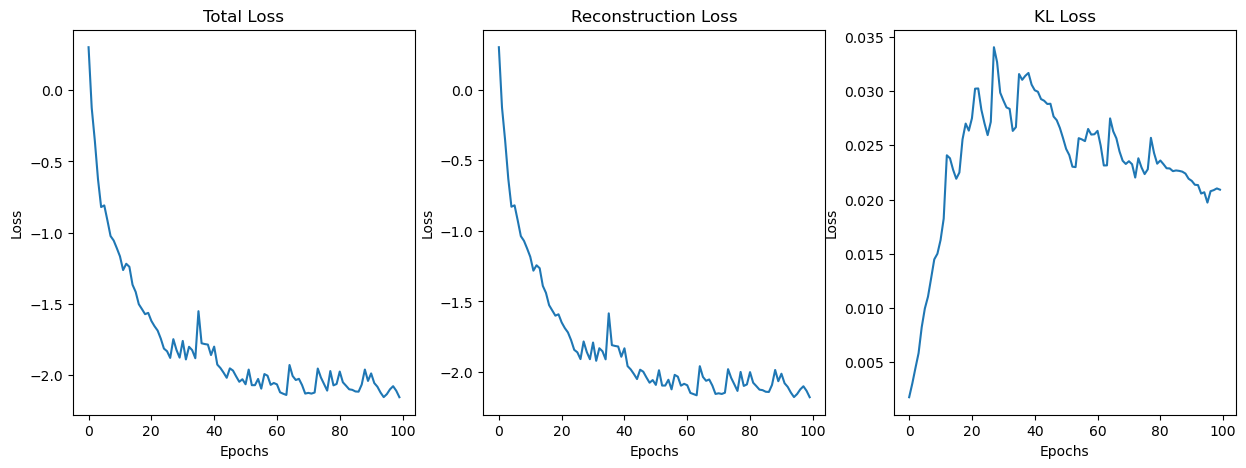

In [339]:
#plot the loss, reconstruction loss, and KL loss 3 in separate plots side by side
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(vae.history.history['loss'])
plt.title('Total Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 3, 2)
plt.plot(vae.history.history['reconstruction_loss'])
plt.title('Reconstruction Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.subplot(1, 3, 3)
plt.plot(vae.history.history['kl_loss'])
plt.title('KL Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')

In [340]:
#pickle the encoder
pickle.dump(encoder, open('encoder.pkl', 'wb'))


INFO:tensorflow:Assets written to: ram://0299610b-d7ce-4040-b47d-542681b8ac29/assets


805/805 [==============================] - 1s 782us/step
(25760, 12)


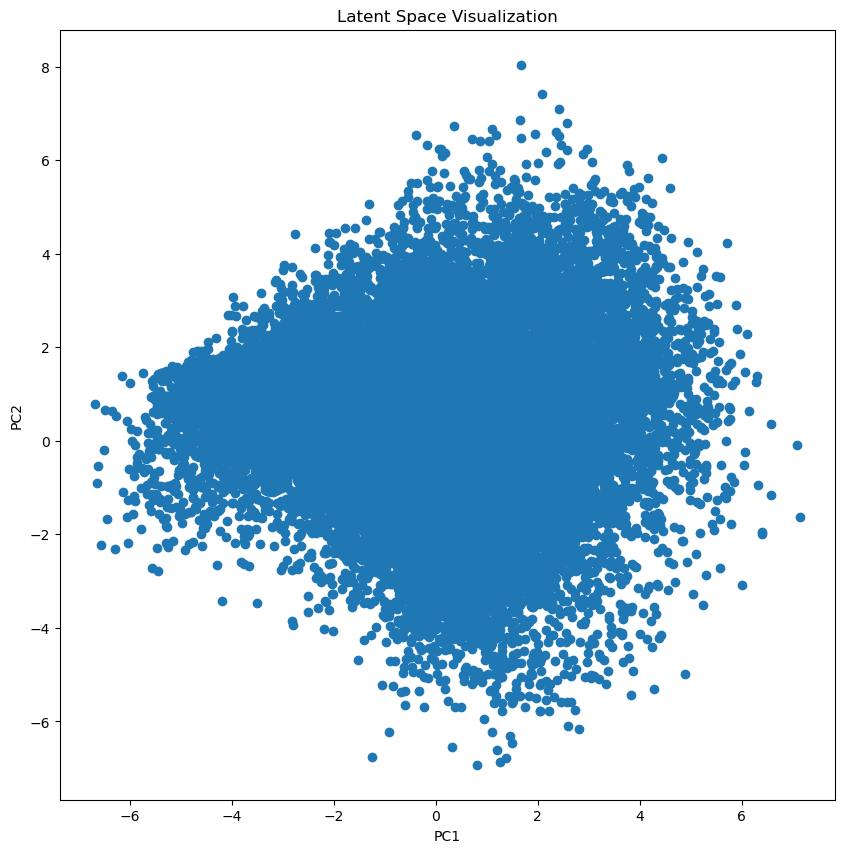

In [341]:
latent_space, _, _ = encoder.predict(X_train_embedding)
print(latent_space.shape)

#visualize the latent space with principal component analysis
pca = PCA(n_components=2)
pca.fit(latent_space)
latent_space_pca = pca.transform(latent_space)

#plot the latent space
plt.figure(figsize=(10, 10))
plt.scatter(latent_space_pca[:, 0], latent_space_pca[:,1])
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Latent Space Visualization')
plt.show()

Text(0, 0.5, 'cumulative explained variance')

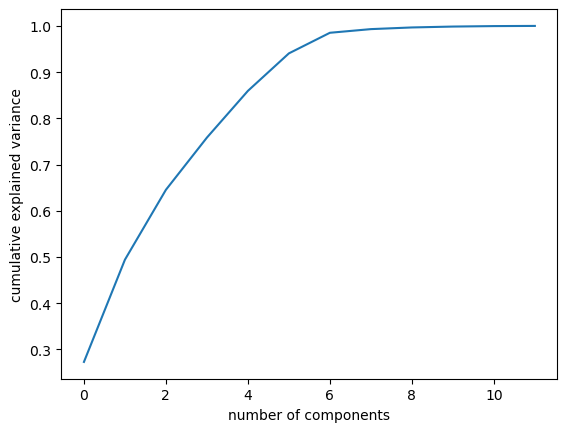

In [342]:
# create a scree plot to see how many components to keep
pca_latent = PCA()
pca_latent.fit(latent_space)
plt.plot(np.cumsum(pca_latent.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')


In [343]:
# a list of genre groups for exercising
exercise_genres = ['pop', 'rock', 'hip_hop', 'metal', 'rap', 'edm', 'electronic', 'house', 'punk']
# a list of genre groups for relaxing
relax_genres = ['r&b', 'adult_standards', 'soul', 'reggae', 'classical', 'jazz', 'ambient']
# a list of genre groups for commmuting
commute_genres = ['pop', 'rock', 'country', 'hip_hop', 'funk', 'latin', 'disco', 'folk', 'rap']

In [344]:


#a function that finds the centroid of a genre group in the latent space
def find_centroid(genre_group):
    #get the index of each song in the genre group
    genre_group_index = np.where(y_train_embedding == genre_group)[0]
    #get the latent space of the genre group
    #print(genre_group_index.shape)
    genre_group_latent_space = latent_space[genre_group_index, :]
    #find the centroid of the genre group
    centroid = np.mean(genre_group_latent_space, axis=0)
    #find the standard deviation of the genre group
    std = np.std(genre_group_latent_space, axis=0)
    #return the centroid and standard deviation
    return centroid, std

#find the centroid of each genre groups above and store them in a dictionary
exercise_centroids = np.array([find_centroid(genre) for genre in exercise_genres])
relax_centroids = np.array([find_centroid(genre) for genre in relax_genres])
commute_centroids = np.array([find_centroid(genre) for genre in commute_genres])

#combine the centroids into a single array with their original lists as labels
centroids = np.concatenate((exercise_centroids, relax_centroids, commute_centroids), axis=0)
activity_labels = ['exercise'] * len(exercise_centroids) + ['relax'] * len(relax_centroids) + ['commute'] * len(commute_centroids)
genre_group_labels = exercise_genres + relax_genres + commute_genres
centroids.shape

(25, 2, 12)

In [345]:
#define user object
class User:
    def __init__(self, user_id, exercise_preferences, relax_preferences, commute_preferences):
        self.user_id = user_id
        self.exercise_preferences = exercise_preferences
        self.relax_preferences = relax_preferences
        self.commute_preferences = commute_preferences
        self.preferences = {'exercise': exercise_preferences, 'relax': relax_preferences, 'commute': commute_preferences}

    def get_user_id(self):
        return self.user_id
    
    def propose_song(self, song_id, activity):
        if activity == 'exercise':
            return song_id in self.exercise_preferences
        elif activity == 'relax':
            return song_id in self.relax_preferences
        elif activity == 'commute':
            return song_id in self.commute_preferences
        
    def give_preference(self, activity):
        if activity == 'exercise':
            #return a random song from the exercise preferences
            return np.random.choice(self.exercise_preferences)
        elif activity == 'relax':
            #return a random song from the relax preferences
            return np.random.choice(self.relax_preferences)
        elif activity == 'commute':
            #return a random song from the commute preferences
            return np.random.choice(self.commute_preferences)
        


#creating a user object

In [346]:
print(type(y_train_embedding.id.values))
print(y_train_embedding.id.shape)
print(latent_space.shape)

<class 'numpy.ndarray'>
(25760,)
(25760, 12)


In [347]:
def create_users(num_users = 3, randomness_percent = 0.1, centroid_radius = 1, random_radius = None, sparsity = 1):
    #create a list will all possible combinations for the genre groups in the exercise, relax, and commute categories
    combinations = list(itertools.product(exercise_genres, relax_genres, commute_genres))

    #create an empty dataframe to store the user data
    user_list = []
    for user in range(num_users):
        #get a random combination of genre groups and remove it from the list of combinations
        exercise_genre, relax_genre, commute_genre = combinations.pop(np.random.randint(len(combinations)))

        #get all of the songs in the latent space that are 1 standard deviation away from the centroid of the exercise genre
        exercise_centroid = exercise_centroids[exercise_genres.index(exercise_genre), 0, :]
        exercise_std = exercise_centroids[exercise_genres.index(exercise_genre), 1, :]
        exercise_index = np.where(np.sum(np.abs(latent_space - exercise_centroid) < exercise_std*centroid_radius, axis=1) == latent_dim)[0]

        #get all of the songs in the latent space that are 1 standard deviation away from the centroid of the relax genre
        relax_centroid = relax_centroids[relax_genres.index(relax_genre), 0, :]
        relax_std = relax_centroids[relax_genres.index(relax_genre), 1, :]
        relax_index = np.where(np.sum(np.abs(latent_space - relax_centroid) < relax_std*centroid_radius, axis=1) == latent_dim)[0]

        #get all of the songs in the latent space that are 1 standard deviation away from the centroid of the commute genre
        commute_centroid = commute_centroids[commute_genres.index(commute_genre), 0, :]
        commute_std = commute_centroids[commute_genres.index(commute_genre), 1, :]
        commute_index = np.where(np.sum(np.abs(latent_space - commute_centroid) < commute_std*centroid_radius, axis=1) == latent_dim)[0]

        #reduce the number of songs in each genre group by a factor of sparsity
        exercise_index = random.sample(list(exercise_index), int(len(exercise_index)*sparsity))
        relax_index = random.sample(list(relax_index), int(len(relax_index)*sparsity))
        commute_index = random.sample(list(commute_index), int(len(commute_index)*sparsity))

        #convert the latent space to a dataframe
        user_df = pd.DataFrame(latent_space)
        user_df['user'] = user
        user_df['exercise'] = 0
        user_df['relax'] = 0
        user_df['commute'] = 0
        
        #set the exercise column to 1 for all of the songs in the exercise genre
        user_df.loc[exercise_index, 'exercise'] = 1
        #set the relax column to 1 for all of the songs in the relax genre
        user_df.loc[relax_index, 'relax'] = 1
        #set the commute column to 1 for all of the songs in the commute genre
        user_df.loc[commute_index, 'commute'] = 1

        #dict to store activity centroids standard deviations, and indexes
        activity_centroids = {'exercise': exercise_centroid, 'relax': relax_centroid, 'commute': commute_centroid}
        activity_stds = {'exercise': exercise_std, 'relax': relax_std, 'commute': commute_std}

        #add some randomness to the data
        #randomly select a percentage of the songs in each genre and switch the activity column
        for activity in ['exercise', 'relax', 'commute']:

            #get the index of the songs in the acttivity
            genre_index = user_df[user_df[activity] == 1].index
            not_genre_index = user_df[user_df[activity] == 0].index

            if random_radius:
                #get the index of the songs in the latent space that are within the random radius of the centroid
                random_index = np.where(np.sum(np.abs(latent_space - activity_centroids[activity]) < activity_stds[activity]*random_radius, axis=1) == latent_dim)[0]
                #get the index of the songs that are in the genre and within the random radius
                not_genre_index = np.intersect1d(not_genre_index, random_index)


            #get the number of songs to switch
            num_switch = int(len(genre_index) * randomness_percent)
            #get the index of the songs to switch


            switch_index_off = np.random.choice(genre_index, num_switch, replace=False)
            switch_index_on = np.random.choice(not_genre_index, num_switch, replace=False)
            #switch the activity column
            user_df.loc[switch_index_off, activity] = 0
            user_df.loc[switch_index_on, activity] = 1
            #switch the activity column for the other two activities

        #reset the activity indexes
        exercise_index = user_df[user_df['exercise'] == 1].index
        relax_index = user_df[user_df['relax'] == 1].index
        commute_index = user_df[user_df['commute'] == 1].index

        ids = y_train_embedding.id.values

        #get the song ids for the exercise, relax, and commute preferences
        exercise_preferences = ids[exercise_index]
        relax_preferences = ids[relax_index]
        commute_preferences = ids[commute_index]

        #create a user object
        user = User(user, exercise_preferences, relax_preferences, commute_preferences)
        user_list.append(user)

    return user_list

In [348]:
#visualze the preferences for one user in a 2d pca plot
def visualize_user_preferences(user, pca_components=2):
    #get the song ids for the exercise, relax, and commute preferences
    exercise_preferences = user.exercise_preferences
    relax_preferences = user.relax_preferences
    commute_preferences = user.commute_preferences

    #get the latent space for the exercise, relax, and commute preferences
    exercise_latent = latent_space[y_train_embedding.id.isin(exercise_preferences)]
    relax_latent = latent_space[y_train_embedding.id.isin(relax_preferences)]
    commute_latent = latent_space[y_train_embedding.id.isin(commute_preferences)]

    #get the rest of the latent space
    rest_latent = latent_space[~y_train_embedding.id.isin(exercise_preferences) & ~y_train_embedding.id.isin(relax_preferences) & ~y_train_embedding.id.isin(commute_preferences)]

    #fit a pca model to the latent space
    pca = PCA(n_components=pca_components)
    pca.fit(latent_space)

    #get the pca components for the exercise, relax, and commute preferences
    exercise_pca = pca.transform(exercise_latent)
    relax_pca = pca.transform(relax_latent)
    commute_pca = pca.transform(commute_latent)
    rest_pca = pca.transform(rest_latent)


    #plot the exercise, relax, and commute preferences
    plt.figure(figsize=(10, 10))

    plt.scatter(rest_pca[:, 0], rest_pca[:, 1], c='k', label='other')
    plt.scatter(exercise_pca[:, 0], exercise_pca[:, 1], c='r', label='exercise')
    plt.scatter(relax_pca[:, 0], relax_pca[:, 1], c='b', label='relax')
    plt.scatter(commute_pca[:, 0], commute_pca[:, 1], c='g', label='commute')
    
    plt.legend()
    plt.show()

In [351]:
def visualize_user_preferences(user, pca_components=2):
    #get the song ids for the exercise, relax, and commute preferences
    exercise_preferences = user.exercise_preferences
    relax_preferences = user.relax_preferences
    commute_preferences = user.commute_preferences

    #get the latent space for the exercise, relax, and commute preferences
    exercise_latent = latent_space[y_train_embedding.id.isin(exercise_preferences)]
    relax_latent = latent_space[y_train_embedding.id.isin(relax_preferences)]
    commute_latent = latent_space[y_train_embedding.id.isin(commute_preferences)]

    #get the rest of the latent space
    rest_latent = latent_space[~y_train_embedding.id.isin(exercise_preferences) & ~y_train_embedding.id.isin(relax_preferences) & ~y_train_embedding.id.isin(commute_preferences)]

    #fit a pca model to the latent space
    pca = PCA(n_components=pca_components)
    pca.fit(latent_space)

    #get the pca components for the exercise, relax, and commute preferences
    exercise_pca = pca.transform(exercise_latent)
    relax_pca = pca.transform(relax_latent)
    commute_pca = pca.transform(commute_latent)
    rest_pca = pca.transform(rest_latent)

    #create the Plotly figure
    fig = go.Figure()

    #add the other songs as a scatter plot
    fig.add_trace(go.Scatter(x=rest_pca[:, 0], y=rest_pca[:, 1], mode='markers', marker_color='black', name='other'))

    #add the exercise, relax, and commute preferences as separate scatter plots
    fig.add_trace(go.Scatter(x=exercise_pca[:, 0], y=exercise_pca[:, 1], mode='markers', marker_color='red', name='exercise'))
    fig.add_trace(go.Scatter(x=relax_pca[:, 0], y=relax_pca[:, 1], mode='markers', marker_color='blue', name='relax'))
    fig.add_trace(go.Scatter(x=commute_pca[:, 0], y=commute_pca[:, 1], mode='markers', marker_color='green', name='commute'))

    #set the plot title and axis labels
    fig.update_layout(title='User Preferences', xaxis_title='PCA Component 1', yaxis_title='PCA Component 2')

    #show the plot
    fig.show()



In [349]:
users_data = create_users(num_users=3, randomness_percent=0.5, centroid_radius=1, random_radius=2.5)

In [355]:
visualize_user_preferences(users_data[2])

In [322]:
num_activities = 3


class GaussianModel:
    def __init__(self, n):
        self.n = n
        self.count = 0
        self.mu = None
        self.sigma = None
        self.params = None
        self.prev_sample = None
    
    def pdf(self, x):
        """
        Compute the probability density function of the Gaussian distribution
        at a given point x.
        """
        assert self.mu is not None and self.sigma is not None, "Model is not fitted"
        return np.exp(-0.5 * (x - self.mu).T @ np.linalg.inv(self.sigma) @ (x - self.mu)) \
            / np.sqrt(((2 * np.pi) ** self.n) * np.linalg.det(self.sigma))
    
    
    def batch_fit_full(self, data):
        """
        Fit a Gaussian distribution with full covariance matrix to a batch of data
        using maximum likelihood estimation.
        """
        assert data.shape[1] == self.n, "Data dimensionality does not match model dimensionality"

        self.count = data.shape[0]

        samples = data.shape[0]
        self.mu = np.mean(data, axis=0)
        self.sigma = np.zeros((self.n, self.n))
        for i in range(samples):
            diff = data[i] - self.mu
            self.sigma += np.outer(diff, diff)
        self.sigma /= samples
        self.params = np.concatenate((self.mu, self.sigma.flatten()))

    def online_fit(self, x):
        alpha_mu = 1 / self.count
        alpha_sigma = alpha_mu * (1 - alpha_mu)
        self.count += 1
        delta = x - self.mu
        self.mu += delta * alpha_mu
        self.sigma += np.outer(delta, delta - (x - self.mu)) * alpha_sigma
        self.count += 1
    
    def get_sample(self, scale=0.1):
        # get a random sample from the gaussian that is near the previous sample
        if self.prev_sample is None:
            #caluculate the standard deviation in each direction
            stds = np.sqrt(np.diag(self.sigma))

            #find all of the point in the latent space that are within 1 standard deviation of the mean
            in_range = np.all(np.abs(latent_space - self.mu) <= stds, axis=1)


            #return a random point from the points in the latent space that are within 1 standard deviation of the mean
            rec = latent_space[np.random.choice(np.where(in_range)[0])]

            return rec
        else:
            #caluculate the standard deviation in each direction
            stds = np.sqrt(np.diag(self.sigma))

            #find all of the point in the latent space that are within 1 standard deviation of the mean
            in_range = np.all(np.abs(latent_space - self.mu) <= stds, axis=1)

            # #convert the full covariance matrix to a circular covariance matrix
            # cov = np.diag(stds**2)
            # #calculate the standard deviation of the circular covariance matrix
            # new_std = np.sqrt(np.diag(cov))

            #find all of the point in the latent space that are within 1 standard deviation of the mean
            in_range_small = np.all(np.abs(latent_space - self.prev_sample) < stds*scale, axis=1)

            #find the points that exist in both ranges
            in_range_both = np.logical_and(in_range, in_range_small)

            #return a random point from the points in the latent space that are within 1 standard deviation of the mean
            rec = latent_space[np.random.choice(np.where(in_range_both)[0])]

            return rec


def create_gaussians(num_examples = 10, user=None):

    gaussians = {}
    all_song_ids = np.empty(num_examples, dtype=object)

    for activity in ['exercise', 'relax', 'commute']:

        #randomly sample songs from the user's preferences
        song_ids = np.random.choice(user.preferences[activity], num_examples)
        #get the indeces of the sond ids in the latent space
        song_indices = np.where(y_train_embedding.id.isin(song_ids))[0]
        #get the latent space vectors for the songs
        latent_space_vectors = latent_space[song_indices, :]

        #fit a gaussian to the latent space vectors
        m_model = GaussianModel(latent_space_vectors.shape[1])
        m_model.batch_fit_full(latent_space_vectors)
        
        #add the gaussian to the dictionary
        gaussians[activity] = m_model
        #add the song ids to the list
        all_song_ids = np.concatenate((all_song_ids, song_ids))

    
    return gaussians, song_ids

def simulate_gmm(num_episodes=100, g_model=None, user=None, pretrain_song_ids=None):

    listen_history = pretrain_song_ids

    num_correct = {activity: 0 for activity in ['exercise', 'relax', 'commute']} #pythonic af
    #instantiate a dictionary of empty 2d arrays to store the means of the gaussians
    means = {activity: np.empty((0, latent_space.shape[1])) for activity in ['exercise', 'relax', 'commute']}
    nearby_count = {activity: 0 for activity in ['exercise', 'relax', 'commute']}

    activity = 'exercise'
    # Loop over the episodes
    for episode in tqdm(range(num_episodes)):

       #add the mean of the gaussian to the means dictionary as a new row
        means[activity] = np.concatenate((means[activity], g_model[activity].mu.reshape(1, -1)), axis=0)

        #switch activities every 10 episodes
        if episode % 10 == 0:
            #if the user is currently exercising, switch to relaxing
            if activity == 'exercise':
                activity = 'relax'
            #if the user is currently relaxing, switch to commuting
            elif activity == 'relax':
                activity = 'commute'
            #if the user is currently commuting, switch to exercising
            elif activity == 'commute':
                activity = 'exercise'

        #get a recommendation from the gaussian model
        recommendation = g_model[activity].get_sample(scale = 0.2)

        #get the index of the recommendation in the latent space
        rec_index = np.where(np.all(latent_space == recommendation, axis=1))[0][0]

        #get the song id
        song_id = y_train_embedding.id.iloc[rec_index]

        #propose the song to the user and check if it was accepted
        if user.propose_song(song_id, activity):
            #update the number of correct recommendations, listen history
            num_correct[activity] += 1
            listen_history = np.append(listen_history, song_id)
            g_model[activity].online_fit(x=recommendation)
            #update the number of correct recommendations, means, listen history
            if nearby_count[activity] < 0:
                #get a new recommendation from the gaussian model
                g_model[activity].prev_sample = recommendation
                nearby_count[activity] += 1
            else:
                #set prev sample to none
                g_model[activity].prev_sample = None
                #get a new recommendation from the gaussian model
                g_model[activity].prev_sample = recommendation
                nearby_count[activity] = 0
        else:
            #reset the previous sample
            nearby_count[activity] = 0
            g_model[activity].prev_sample = None



    return {activity: num_correct[activity] for activity in ['exercise', 'relax', 'commute']}, g_model, means

In [323]:
#create the gaussian models
gaussians, pretrain_song_ids = create_gaussians(num_examples=4, user=users_data[0])
g1 = gaussians.copy()

In [324]:
num_correct, models, means = simulate_gmm(g_model=gaussians, user=users_data[0], pretrain_song_ids=pretrain_song_ids, num_episodes=3000)

100%|██████████| 3000/3000 [00:11<00:00, 267.57it/s]


In [290]:
print(num_correct)
#print the sum of num_correct
print(sum(num_correct.values()))


{'exercise': 1000, 'relax': 994, 'commute': 994}
2988


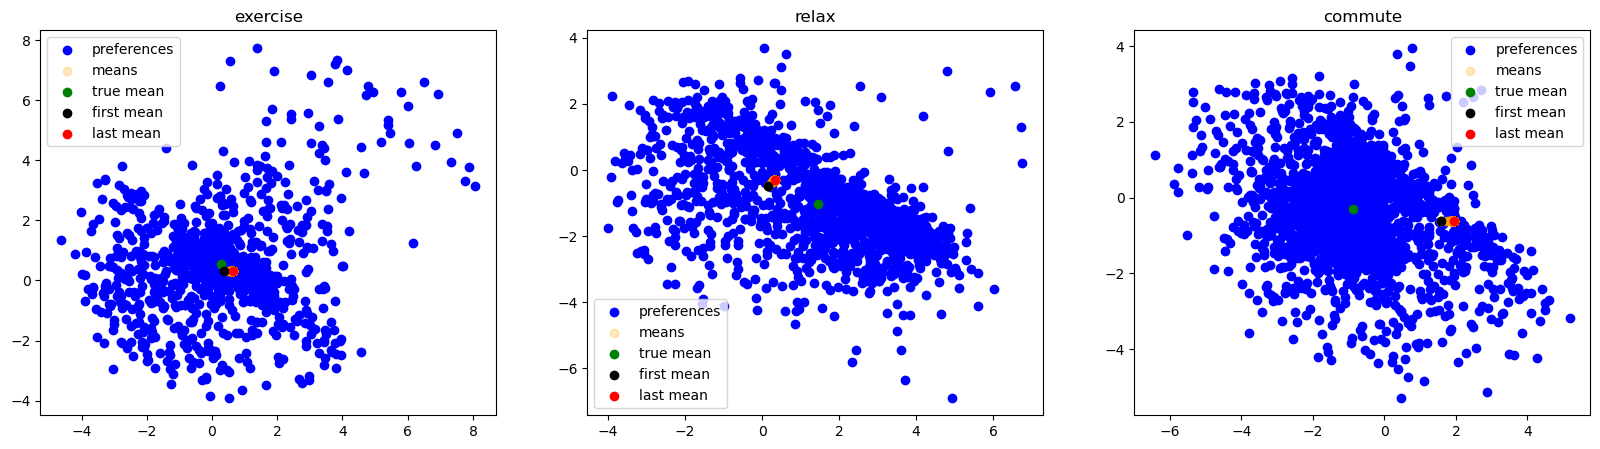

In [291]:
pca = PCA(n_components=2)
pca.fit(latent_space)

#plot the pca of users  preferences and the means of the gaussians over the latent space
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, activity in enumerate(['exercise', 'relax', 'commute']):

    #get the indeces of the songs in the latent space
    song_indices = np.where(y_train_embedding.id.isin(users_data[2].preferences[activity]))[0]
    #get the latent space vectors for the songs
    latent_space_vectors = latent_space[song_indices, :]
    #plot the latent space vectors
    ax[i].scatter(pca.transform(latent_space_vectors)[:,0],  pca.transform(latent_space_vectors)[:,1], color='blue', label='preferences')

    # #plot all of the means of the gaussians models
    ax[i].scatter(pca.transform(means[activity])[:,0], pca.transform(means[activity])[:,1], color='orange', label='means', alpha=0.25)

    #plot the true mean of the songs
    ax[i].scatter(pca.transform(np.mean(latent_space_vectors, axis=0).reshape(1, -1))[0][0], pca.transform(np.mean(latent_space_vectors, axis=0).reshape(1, -1))[0][1], color='green', label='true mean')

    # #plot all of the means of the gaussians models
    ax[i].scatter(pca.transform(means[activity])[0,0], pca.transform(means[activity])[0,1], color='black', label='first mean')
    ax[i].scatter(pca.transform(means[activity])[-1,0], pca.transform(means[activity])[-1,1], color='red', label='last mean')


    ax[i].set_title(activity)
    ax[i].legend()


In [54]:
#plot all of the means of the gaussians over the latent space
fig, ax = plt.subplots(1, 3, figsize=(20, 5))

for i, activity in enumerate(['exercise', 'relax', 'commute']):
    #

    #plot the true mean of the songs 
    ax[i].scatter(np.mean(latent_space, axis=0)[0], np.mean(latent_space, axis=0)[1], color='green', label='true mean')
  

    #plot the mearn of the songs
    ax[i].scatter(np.mean(latent_space, axis=0)[0], np.mean(latent_space, axis=0)[1], color='green', label='true mean')

    ax[i].set_title(activity)
    ax[i].legend()


Gaussian Mixture Model
Activity	Accuracy
exercise		1.0
relax		1.0
commute		1.0
